# Customer Churn Dataset Analysis
#### Jesse Coulson


## Purpose
We're looking at the customer churn dataset for a bank to figure out which factors make a customer leave or stay. Our plan is to do a thorough exploratory data analysis to pick out the main variables that affect whether a customer leaves. We will then use these features for creating multiple models.

These models will help us see how well we can predict customer churn. We want to use this analysis to be able to help a bank figure out better ways to keep customers from leaving. This way  efforts to hold onto customers can based on solid data and can effectively target their concerns

In [47]:
#libraries needed for this ipynb
import seaborn as sns
import pandas as pd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

## Reading in Data and Checking Format

In [48]:
#read in df
df= pd.read_csv("customer_churn.csv")

#print data to see data and format
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [49]:
#get info of types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Satisfaction Score  10000 non-null  int64  
 15  Card Type           10000 non-null  object 
 16  Point

## Exploratory Data Analysis
 - Transforming all the categoricorical variables to numeric
 - Performing feature engineering and feature extraction
 - Creating visualisations to analyze features


## Setting up variables
 - Categorizing all variables into their types
 - Using encoders for each variable type with column transformer to prepare all independent variables

In [50]:
#irrelevant to modeling so removing
df = df.drop(columns=['RowNumber','CustomerId', 'Surname'])

#putting each type of var into list
bin_vars = ['Gender']
onehot_vars = ['Geography']
ordinal_vars = ['Card Type']
numeric_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Satisfaction Score', 'Point Earned'] #var names for labeling

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#creating pipeline for preprocessing, using imputer for missing vals
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())])

#column transform to tansform all features at once
column_transformer = ColumnTransformer(transformers=[
('onehot', categorical_transformer, onehot_vars), #non hierarchael categorical varai are one hot encoded
('ordinal', OrdinalEncoder(), ordinal_vars), #hierarchechal categorical variables are ordinal encoded
('bin', binary_transformer, bin_vars) #ordinal encoder also works for binary variables
],
remainder='passthrough' #anything not transformed is passed over
)

In [52]:
#transform all the data of the dataframe
transformed_data = column_transformer.fit_transform(df)
#onehot naming needs to be special because of new variables created
onehot_feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out()
all_feature_names = np.concatenate([onehot_feature_names, ordinal_vars, bin_vars, numeric_vars])
#the transformed data and names are turned into dataframe
df = pd.DataFrame(transformed_data, columns=all_feature_names)
df.head()

,Geography_France,Geography_Germany,Geography_Spain,Card Type,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Point Earned
0,1.0,0.0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0,2.0,464.0
1,0.0,0.0,1.0,0.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,3.0,456.0
2,1.0,0.0,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0,3.0,377.0
3,1.0,0.0,0.0,1.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,5.0,350.0
4,0.0,0.0,1.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,5.0,425.0


## Exploring Dataset Further
 - Checking the unique values and counts for quality since it appears the dataset is missing some of the numbers on the 1-10 scale
 - Also checking metrics for the dataframe and making sure no missing values

In [53]:
#distribution of quality variable is weird, will explore further
print("The unique score of target variable, Exited")
print(df['Exited'].unique())

#individual count of each quality score
print("\nCount of each score:")
print(df['Exited'].value_counts(), "\n")

#see statistics for each feature
df.describe(include='all')

The unique score of target variable, Exited
[1. 0.]

Count of each score:
Exited
0.0    7962
1.0    2038
Name: count, dtype: int64 



,Geography_France,Geography_Germany,Geography_Spain,Card Type,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.501400,0.250900,0.247700,1.498000,0.545700,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,3.013800,606.515100
std,0.500023,0.433553,0.431698,1.118356,0.497932,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,1.405919,225.924839
min,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,1.000000,119.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,2.000000,410.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,3.000000,605.000000
75%,1.000000,1.000000,0.000000,2.000000,1.000000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,4.000000,801.000000
max,1.000000,1.000000,1.000000,3.000000,1.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,5.000000,1000.000000


### Further Dataset Exploration Conclusion
There are no missing values in this dataset. Once again the difference in scale and types of the variables are seen from the describe function. Our target variable Exited is a binary 1 or 0 with a lot more samples of customers staying than leaving. There's some interesting insights in this describe such as the average age being 39, the average tenure only being 5 years, and the most frequent gender being male.

## Creating Histograms of All the Variables 
- Seeing the distribution of values for each variable

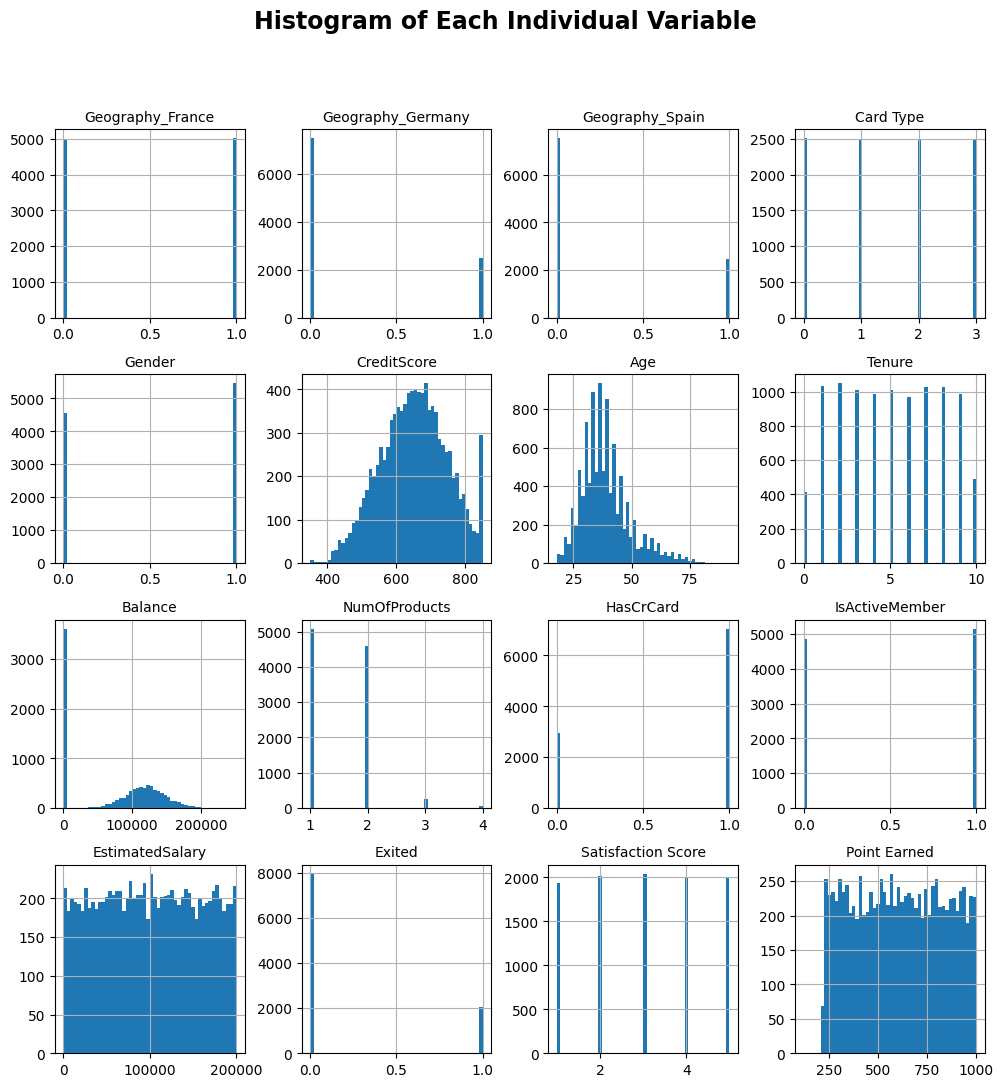

In [54]:
#histograms of the variables
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
#small plots side by side
df.hist(bins=50, figsize=(12, 12))
#title for histograms
plt.suptitle('Histogram of Each Individual Variable', fontsize=17, fontweight = "bold",verticalalignment='top', horizontalalignment='center')
plt.show()


### Histograms conclusion
There are interesting insights to be found from these histograms. The first thing noticeable is the scale of each variable. There is a very large variance in the scale, for example age appears to be between 25 and 75 while the estimated salary is between 0 and 200,0000. To deal with this we will do some normalization later to put them on same scale. Another insight is that there are a lot of binary and categorical variables. We created some of these with the geographical one hot encoding, but we will keep this in mind. Another thing interesting is the distributions, as you can see a large amount of customers have a balance of 0, we will see how that impacts the modeling later

## Feature engineering and selection
 - Creating correlation matrixes to see variable relationships
 - Will use this information to combine variables and select the most relevant variables for modeling

In [55]:
#seeing correlation between dependant vars and target
corr_matrix = df.corr(numeric_only= True)
corr_matrix["Exited"].sort_values(ascending=False)

Exited                1.000000
Age                   0.285296
Geography_Germany     0.173313
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Card Type            -0.010861
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
Geography_Spain      -0.052800
Geography_France     -0.104688
Gender               -0.106267
IsActiveMember       -0.156356
Name: Exited, dtype: float64

In [56]:
#Checking variables that are correlated with balance to see if any potential combinations
corr_matrix = df.corr(numeric_only= True)
corr_matrix["Balance"].sort_values(ascending=False)

Balance               1.000000
Geography_Germany     0.401110
Exited                0.118577
Age                   0.028308
Point Earned          0.014608
EstimatedSalary       0.012797
Gender                0.012087
CreditScore           0.006268
Satisfaction Score   -0.002588
IsActiveMember       -0.010084
Tenure               -0.012254
HasCrCard            -0.014858
Card Type            -0.027059
Geography_Spain      -0.134892
Geography_France     -0.231329
NumOfProducts        -0.304180
Name: Balance, dtype: float64

In [57]:
#isactivemember is other var to check since it has good correlation with Exited but not extremely
corr_matrix = df.corr(numeric_only= True)
corr_matrix["IsActiveMember"].sort_values(ascending=False)

IsActiveMember        1.000000
Age                   0.085472
CreditScore           0.025651
Gender                0.022544
Geography_Spain       0.016732
Card Type             0.016247
Satisfaction Score    0.010236
NumOfProducts         0.009612
Geography_France      0.003317
Point Earned         -0.004983
Balance              -0.010084
EstimatedSalary      -0.011421
HasCrCard            -0.011866
Geography_Germany    -0.020486
Tenure               -0.028362
Exited               -0.156356
Name: IsActiveMember, dtype: float64

In [58]:
#balance is negatively correlated with num of products which makes sense, trying to combine
df['Balance_num'] = df['Balance'] * df['NumOfProducts'] 
#creditscore and active member is a combination i want to explore if it ahs merit
df['creditcard_usage'] = df['CreditScore'] * df['IsActiveMember']

In [59]:
#seeing correlation between dependant vars and target
corr_matrix = df.corr(numeric_only= True)
corr_matrix["Exited"].sort_values(ascending=False)

Exited                1.000000
Age                   0.285296
Geography_Germany     0.173313
Balance_num           0.133604
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Card Type            -0.010861
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
Geography_Spain      -0.052800
Geography_France     -0.104688
Gender               -0.106267
IsActiveMember       -0.156356
creditcard_usage     -0.157218
Name: Exited, dtype: float64

### Feature engineering/selection conclusion
The variables I created Balance_num, and creditcard_usage have more correlation with the target variable than their components. They were created after testing multiple feature combinations, these made sense logically and had large correlations with each other. Overall looking at all the correlations to the target, I chose features that I will explore further.  

## Making visualizations of promising variables
 - Exploring anything above |.13| correlation threshold
     - Age, Balance_num, creditcard_usage, Geography_Germany
 - Creating boxplots and barplots of these features
 - Setting up features for model input and doing TSNE visualization

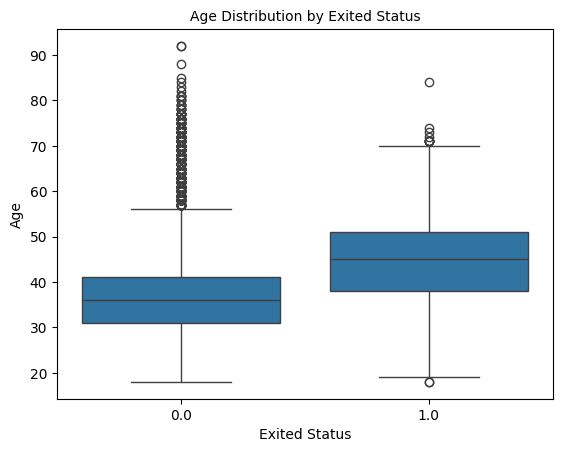

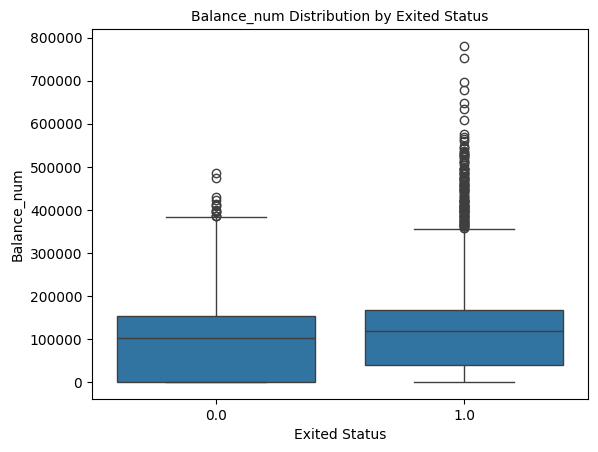

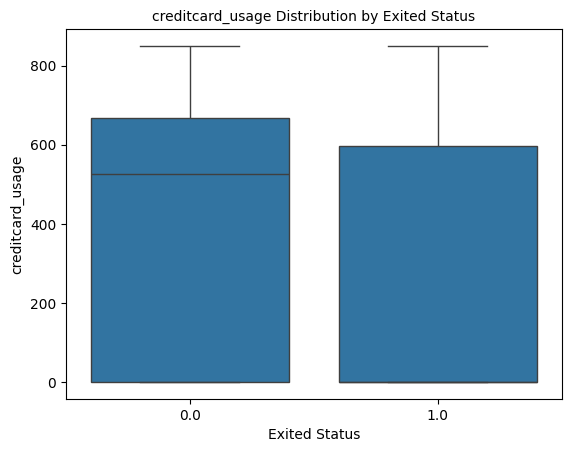

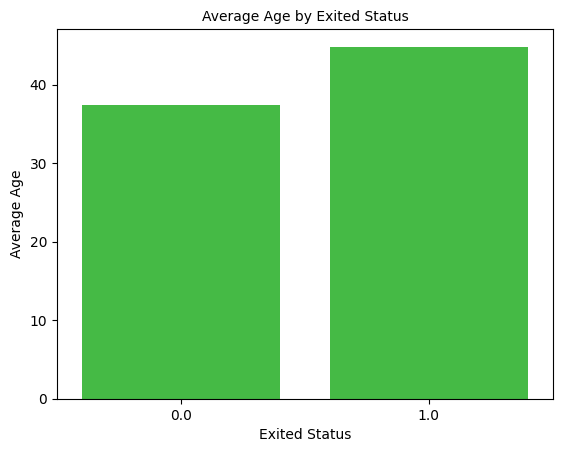

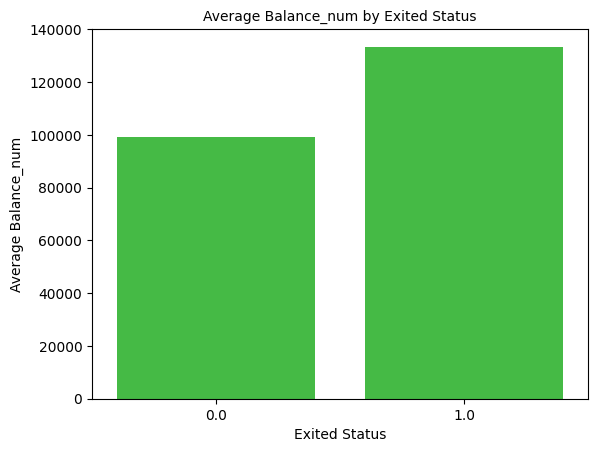

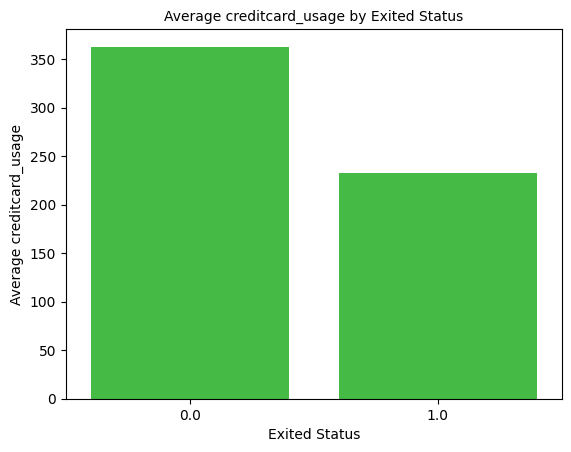

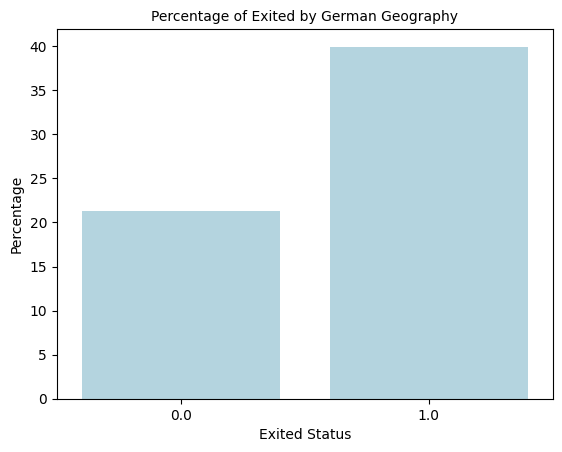

<Figure size 640x480 with 0 Axes>

In [60]:
#list of continuous variables
variables = ['Age', 'Balance_num', 'creditcard_usage' ]

#creating boxplots for each variable
for var in variables:
    sns.boxplot(x='Exited', y=var, data=df)
    plt.title(f'{var} Distribution by Exited Status')
    plt.xlabel('Exited Status')
    plt.ylabel(var)
    plt.show()
    plt.clf()  # Clear the figure to avoid overlap

#creating barplots for each variable
for var in variables:
    sns.barplot(x='Exited', y=var, data=df, errorbar=None, color="limegreen")  # ci=None to remove the error bars
    plt.title(f'Average {var} by Exited Status')
    plt.xlabel('Exited Status')
    plt.ylabel(f'Average {var}')
    plt.show()
    plt.clf()


sns.barplot(x='Exited', y='Geography_Germany', data=df, color="lightblue",estimator=lambda x: sum(x)*100/len(x), errorbar=None)
plt.title('Percentage of Exited by German Geography')
plt.xlabel('Exited Status')
plt.ylabel('Percentage')
plt.show()
plt.clf()



### Boxplots and Barplots conclusion
From these visualsations we can see these features are very good. There is a significant difference in the variables in relation to exiting or not. For example the average age that exited is about 47 but the average age that stayed is about 35. Overall we can conclude that these features are influential in predicting customer churn. 

In [61]:
#scaling all the non binary variablers
continuous_columns = ['Age', 'Balance_num', 'creditcard_usage']

X = df[['Age', 'Balance_num', 'creditcard_usage', 'Geography_Germany']] 
y = df['Exited'] #get target feature

In [71]:
scaler = MinMaxScaler()
#scaling vars for tsne
X_scaled= scaler.fit_transform(X)

#using TSNE to go to reduce dimensionality to two dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

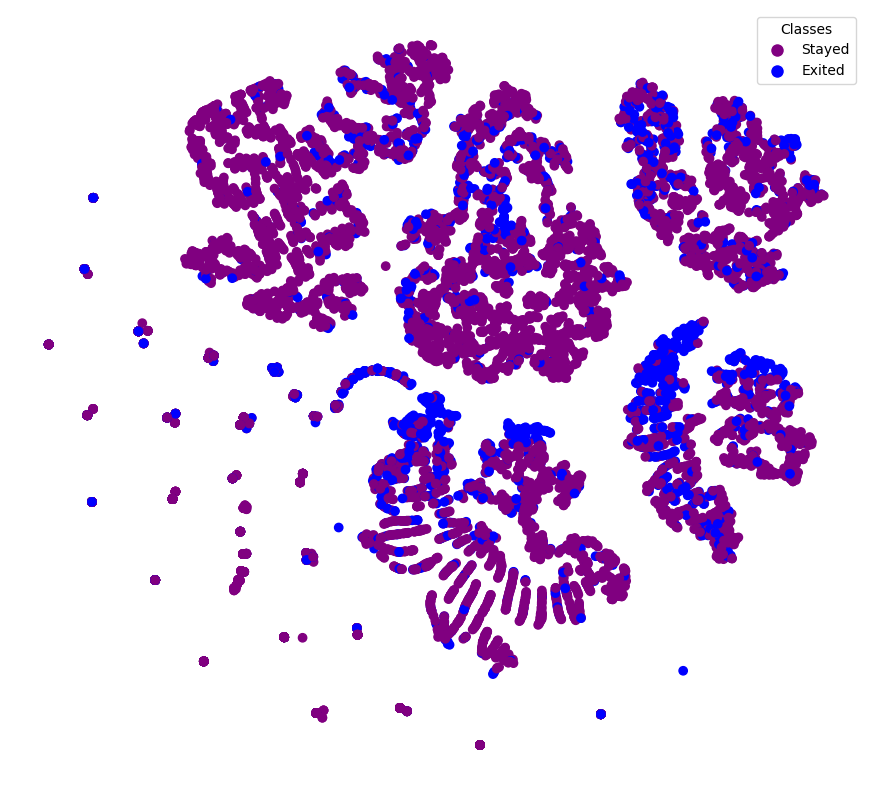

In [72]:
#using blue and purple as colors for the classes
cmap = ListedColormap(['purple', 'blue'])

#visualising 2d TSNE
plt.figure(figsize=(11,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap)
plt.axis('off')#no axis needed because scale is from reduced dimension vars

#creating legend
colors = ['purple', 'blue']  #colors used for scatter
classes = ['Stayed', 'Exited']  #labeling the classes
#necissary for labeling classes
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, classes, title="Classes")
plt.show()

### TSNE conclusion
Looking at the t-SNE visualization, we can see that there’s a pretty good separation between the two classes, which suggests that our features might be strong enough for effective modeling. Although there’s noticeable separation, some areas do show overlap of the two classes. This overlap points out places where the features don't do as great a job at differentiating between the classes, or it could highlight some inherent similarities within the data.

Considering the separation observed, it seems likely that our upcoming models should perform well. We will use a model that is good with this kind of data structure such as an SVM, because it works on the principle of finding differences in data point locations.

# Using kfold Cross Validation for Initial Model Performance
 - Creating a pipeline that scales the features then models
 - Splitting the data into training and testing
 - For analyzing the models I will use kfold cross validation with metrics of accuracy, precision, recall, and f1 score
 - The models I will use are Logistic Regression and SVC. Logistic Regression will be a baseline and SVC should be able to have strong results based on teh models capabilities

In [64]:
#modeling pipelines
logistic_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), #scaling because values are very different between vars
    ('classifier', LogisticRegression())
])

svc_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('classifier', SVC(probability=True))
])

#splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(
   X, y, random_state=42)


## Logistic Regression Model

In [65]:
#scoring metrics for classification
score_list = ['accuracy', 'precision', 'recall', 'f1']

#doing cross validation with 5 folds
scores = cross_validate(logistic_pipeline, X_train, y_train, scoring=score_list, cv=5, return_train_score=False)

#logistic regression results
print("----Logistic Regression kfold----")
print("Accuracy for each fold:")
for i, fold_accuracy in enumerate(scores["test_accuracy"]):
    print(f"Fold {i} accuracy: {fold_accuracy}")

print("\nPrecision for each fold:")
for i, fold_precision in enumerate(scores["test_precision"]):
    print(f"Fold {i} precision: {fold_precision}")

print("\nRecall for each fold:")
for i, fold_recall in enumerate(scores["test_recall"]):
    print(f"Fold {i} recall: {fold_recall}")

print("\nF1 Score for each fold:")
for i, fold_f1 in enumerate(scores["test_f1"]):
    print(f"Fold {i} F1 score: {fold_f1}")

----Logistic Regression kfold----
Accuracy for each fold:
Fold 0 accuracy: 0.81
Fold 1 accuracy: 0.8006666666666666
Fold 2 accuracy: 0.8146666666666667
Fold 3 accuracy: 0.8113333333333334
Fold 4 accuracy: 0.816

Precision for each fold:
Fold 0 precision: 0.6333333333333333
Fold 1 precision: 0.5616438356164384
Fold 2 precision: 0.6829268292682927
Fold 3 precision: 0.6086956521739131
Fold 4 precision: 0.6904761904761905

Recall for each fold:
Fold 0 recall: 0.18446601941747573
Fold 1 recall: 0.1331168831168831
Fold 2 recall: 0.18181818181818182
Fold 3 recall: 0.22727272727272727
Fold 4 recall: 0.18831168831168832

F1 Score for each fold:
Fold 0 F1 score: 0.2857142857142857
Fold 1 F1 score: 0.2152230971128609
Fold 2 F1 score: 0.28717948717948716
Fold 3 F1 score: 0.3309692671394799
Fold 4 F1 score: 0.29591836734693877


## Support Vector Classifier Model

In [66]:
score_list = ['accuracy', 'precision', 'recall', 'f1']

#input the pipeline
scores = cross_validate(svc_pipeline, X_train, y_train, scoring=score_list, cv=5, return_train_score=False)

#svc results
print("----SVC kfold----")
print("Accuracy for each fold:")
for i, fold_accuracy in enumerate(scores["test_accuracy"]):
    print(f"Fold {i} accuracy: {fold_accuracy}")

print("\nPrecision for each fold:")
for i, fold_precision in enumerate(scores["test_precision"]):
    print(f"Fold {i} precision: {fold_precision}")

print("\nRecall for each fold:")
for i, fold_recall in enumerate(scores["test_recall"]):
    print(f"Fold {i} recall: {fold_recall}")

print("\nF1 Score for each fold:")
for i, fold_f1 in enumerate(scores["test_f1"]):
    print(f"Fold {i} F1 score: {fold_f1}")

----SVC kfold----
Accuracy for each fold:
Fold 0 accuracy: 0.83
Fold 1 accuracy: 0.8306666666666667
Fold 2 accuracy: 0.8373333333333334
Fold 3 accuracy: 0.84
Fold 4 accuracy: 0.836

Precision for each fold:
Fold 0 precision: 0.8068181818181818
Fold 1 precision: 0.8461538461538461
Fold 2 precision: 0.8404255319148937
Fold 3 precision: 0.7931034482758621
Fold 4 precision: 0.8522727272727273

Recall for each fold:
Fold 0 recall: 0.2297734627831715
Fold 1 recall: 0.21428571428571427
Fold 2 recall: 0.2564935064935065
Fold 3 recall: 0.2987012987012987
Fold 4 recall: 0.2435064935064935

F1 Score for each fold:
Fold 0 F1 score: 0.35768261964735515
Fold 1 F1 score: 0.34196891191709844
Fold 2 F1 score: 0.39303482587064675
Fold 3 F1 score: 0.4339622641509434
Fold 4 F1 score: 0.3787878787878788


### kfold Results
The k-fold cross-validation results shows that the SVC model  outperforms Logistic Regression model across various metrics. SVC shows greater stability and is more accurate in its predictions across all folds. The results across different folds show that the data has a uniform distribution. More detailed analysis on the exact metrics will be explored in the final conclusions after evaluating the test data. 

## Using Test Set and Final Results
- We will obtain metrics of accuracy, precision, recall, and f1-score from the test set to assess model performance
- Analysis of these metrics will help identify the best performing model and the mathematical equation will be showcased for Logistic Regression
- After generating the confusion matrix and ROC curve, a final analysis will be conducted to evaluate model effectiveness

In [67]:
svc_pipeline.fit(X_train, y_train)
y_pred_svc = svc_pipeline.predict(X_test)
y_scores_svc = svc_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

print("SVC metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Precision:", precision_score(y_test, y_pred_svc, average='binary'))
print("Recall:", recall_score(y_test, y_pred_svc, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred_svc, average='binary'))
print("\n------------")



# Logistic Regression
logistic_pipeline.fit(X_train, y_train)
y_pred_log = logistic_pipeline.predict(X_test)
y_scores_log = logistic_pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

print("Logistic Regression metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, average='binary'))
print("Recall:", recall_score(y_test, y_pred_log, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred_log, average='binary'))



SVC metrics:
Accuracy: 0.8412
Precision: 0.8378378378378378
Recall: 0.24949698189134809
F1 Score: 0.38449612403100775

------------
Logistic Regression metrics:
Accuracy: 0.8124
Precision: 0.5864197530864198
Recall: 0.19114688128772636
F1 Score: 0.2883156297420334


## Model Equation for the Logistic Regression model

In [68]:
#accessing the model from pipeline
logistic_model = logistic_pipeline.named_steps['classifier']
#printing bias and parameters
logistic_model.intercept_, logistic_model.coef_


(array([-2.8928033]),
 array([[ 5.13268919,  1.51899792, -1.37229954,  0.68218578]]))

#### Linear Combination Equation:

\begin{equation*}
z = -2.89 + 5.13 \times \mathbf{X}_1  + 1.51\times \mathbf{X}_2 - 1.37\times \mathbf{X}_3 +0.68\times \mathbf{X}_4 
\end{equation*}

\begin{equation*}
z = -2.89 + 5.13 \times \textbf{Age} + 1.51 \times \textbf{Balance\_num} - 1.37 \times \textbf{creditcard\_usage} + 0.68 \times \textbf{Geography\_Germany}
\end{equation*}

#### Logistic Function for Probability:

\begin{equation*}
\hat{p} = \frac{1}{1 + e^{-(z)}}
\end{equation*}

#### Decision Rule for Classification

\begin{equation*}
\hat{y} = \begin{cases} 
1 & \text{if } \hat{p} \geq 0.5 \\
0 & \text{if } \hat{p} < 0.5 
\end{cases}
\end{equation*}

## Final Visualisations

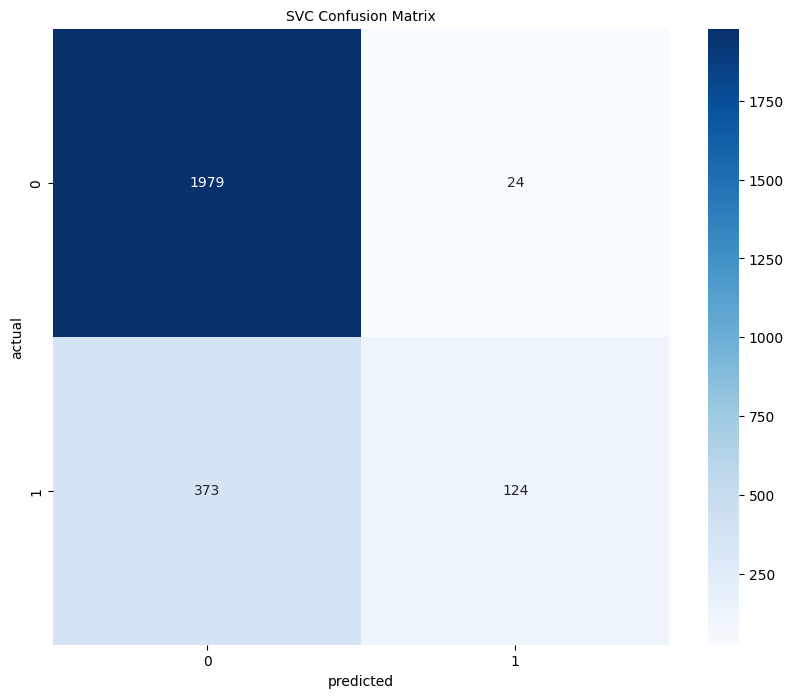

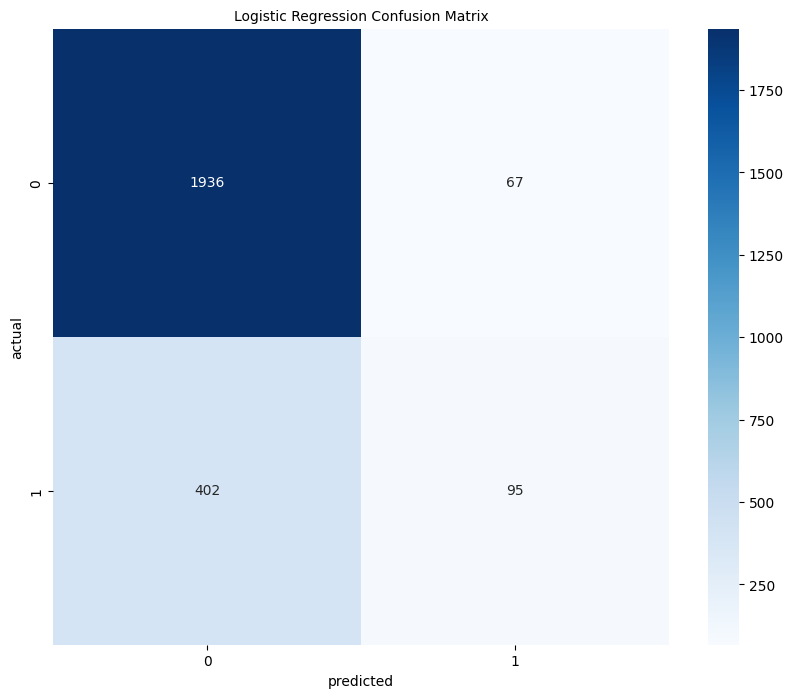

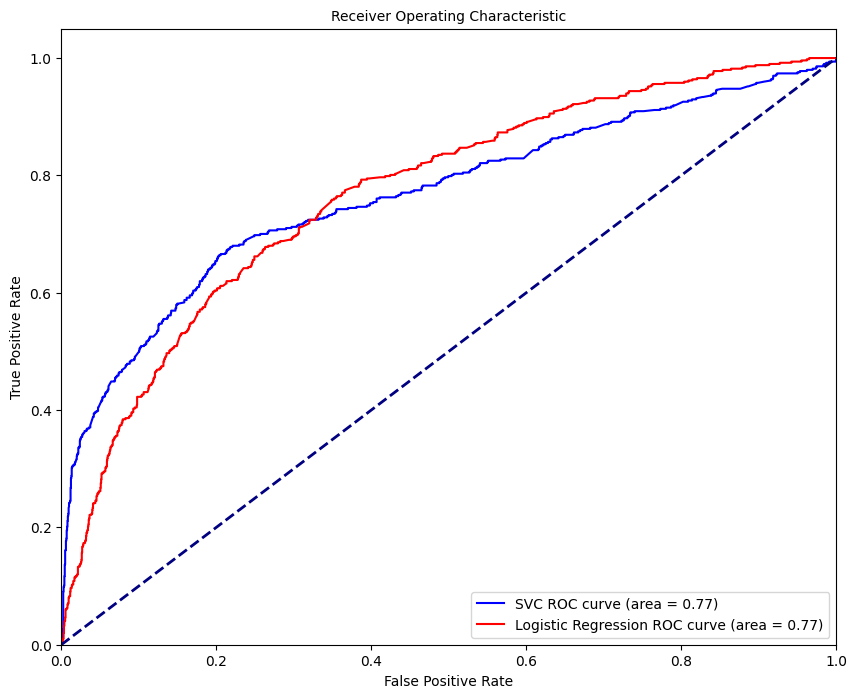

In [69]:
conf_matrix = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(10, 8))
plt.title('SVC Confusion Matrix')
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual')


conf_matrix = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(10, 8))
plt.title('Logistic Regression Confusion Matrix')
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual')

# Plotting ROC Curve for SVC
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_scores_svc)
auc_svc = roc_auc_score(y_test, y_scores_svc)
plt.figure(figsize=(10, 8))
plt.plot(fpr_svc, tpr_svc, label='SVC ROC curve (area = %0.2f)' % auc_svc, color='blue')

# Plotting ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
auc_log = roc_auc_score(y_test, y_scores_log)
plt.plot(fpr_log, tpr_log, label='Logistic Regression ROC curve (area = %0.2f)' % auc_log, color='red')

# Finalizing the plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Final Conclusions on Model Performance
In reviewing the metrics, the Support Vector Classifier (SVC) seems to be the more effective model over Logistic Regression, particularly in accuracy and precision. The SVC achieves an accuracy of 0.8404, meaning that it correctly predicts outcomes 84.04% of the time, compared to Logistic Regression, which has an accuracy of 81.24%. Precision for SVC is 0.8356, meaning that of all instances classified as positive, 83.56% were actually positive. This is significantly better than the precision of 0.5864 for Logistic Regression, which indicates that only 58.64% of its positive predictions were correct, reflecting a higher rate of false positives compared to SVC.

Recall for SVC is at 0.2455, which is fairly low. It shows that the model correctly identifies 24.55% of all actual positives. This is a bit better compared to 19.11% for Logistic Regression. The F1 Score, which harmonizes precision and recall, is 0.3795 for SVC versus 0.2883 for Logistic Regression, indicating a more consistent and balanced performance between precision and recall for SVC. The confusion matrix provides further insights. SVC correctly predicted 1979 true negatives and 375 true positives, where Logistic Regression managed 1936 true negatives but only 402 true positives. This shows that while Logistic Regression is somewhat effective in capturing true positives, it struggles more with false positives compared to SVC.

Both models display an ROC curve area of 0.77, demonstrating a decent capability to distinguish between the classes. Still, given the individual performance metrics, SVC, with its higher precision and reasonable recall, is the better model. Especially if whoever was using the model wants low false positives.